# 3 Implemetning a GPT model from scratch to genrate text

# 3.1 Coding an LLM architecture

In [1]:
GPT_CONFIG_124M={
    "vocab_size":50257,
    "context_length":1024,
    "emb_dim":1600,
    "n_heads":25,
    "n_layers":48,
    "drop_rate":0.1,
    "qkv_bias":False
}

In [2]:
import torch
import torch.nn as nn

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()

    def forward(self, x):
        return x


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.out_head(x)
        return x


In [3]:
import tiktoken
# import torch

tokenizer= tiktoken.get_encoding("gpt2")

batch=[]

txt1="Every effort moves you"
txt2="Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch=torch.stack(batch,dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [4]:
torch.manual_seed(123)
model=DummyGPTModel(cfg=GPT_CONFIG_124M)

logits=model(batch)
print("Output Shape:",logits.shape)
print(logits)

Output Shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1251,  1.1525, -1.3001,  ..., -0.4876,  0.5665,  0.5488],
         [ 0.6978, -0.3196, -0.0894,  ...,  1.9334,  0.4320, -1.5909],
         [ 0.0477,  0.0577, -0.2911,  ...,  0.0302,  0.7183, -1.5870],
         [-1.2839,  0.8085, -0.4529,  ...,  0.2904,  0.4932,  0.9286]],

        [[-0.1847,  1.5396, -1.7063,  ..., -0.2936,  0.3621, -0.0771],
         [-0.9853, -0.8396,  0.5931,  ...,  2.1843,  0.7224, -2.3603],
         [ 0.2480, -0.5340,  0.0893,  ...,  0.2701,  0.6715, -1.0017],
         [-1.3378, -0.4632, -1.3422,  ..., -0.6862,  0.1981,  0.2137]]],
       grad_fn=<UnsafeViewBackward0>)


# 3.2 Normalizing activations with layer normalization

In [5]:
class LayerNorm(nn.Module):
    def __init__(self,emb_dim):
        super().__init__()
        self.eps=1e-5
        self.scale=nn.Parameter(torch.ones(emb_dim))
        self.shift=nn.Parameter(torch.zeros(emb_dim))

    def forward(self,x):
        mean=x.mean(dim=-1,keepdim=True)
        var= x.var(dim=-1,keepdim=True,unbiased=False)
        norm_x=(x-mean) / torch.sqrt(var+ self.eps)
        return self.scale * norm_x + self.shift

In [6]:
import torch
import torch.nn as nn

batch_example = torch.randn(2, 100)   # 2 samples, 100 features each
layer = nn.Sequential(nn.Linear(100, 1000), nn.ReLU())

out = layer(batch_example)
print(out.shape)


torch.Size([2, 1000])


In [7]:
ln=LayerNorm(1000)
output_normed=ln(out)

In [8]:
output_normed

tensor([[-0.7011,  0.7031, -0.4287,  ...,  1.0760, -0.7011, -0.5268],
        [-0.6927,  1.8930, -0.6927,  ..., -0.6927,  0.7123, -0.6927]],
       grad_fn=<AddBackward0>)

# 3.3 Implementing a feed forward network with GELU activations

In [9]:
 class GELU(nn.Module):
    def __init__(self):
         super().__init__()

    def forward(self,x):
        return 0.5 * x *(1+torch.tanh(
            torch.sqrt(torch.tensor(2.0/torch.pi))*
            (x+0.044715*torch.pow(x,3))
        ))

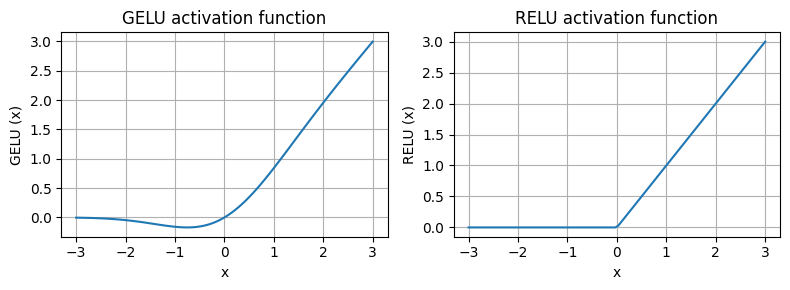

In [10]:
import matplotlib.pyplot as plt

gelu,relu=GELU(),nn.ReLU()

x=torch.linspace(-3,3,100)
y_gelu,y_relu = gelu(x) , relu(x)

plt.figure(figsize=(8,3))

for i, (y,label) in enumerate(zip([y_gelu,y_relu] , ["GELU","RELU"]),1):
    plt.subplot(1,2,i)
    plt.plot(x,y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label} (x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [11]:
class FeedForward(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.layers=nn.Sequential(
        nn.Linear(cfg["emb_dim"] , 4 * cfg["emb_dim"]),
        GELU(),
        nn.Linear(4 * cfg["emb_dim"] , cfg["emb_dim"]),
        )

    def forward(self,x):
        return self.layers(x)

In [12]:
ffn=FeedForward(GPT_CONFIG_124M)

In [13]:
x= torch.rand(2,3,1600)
ffn(x).shape

torch.Size([2, 3, 1600])

# 3.4 Adding shortcut connections

In [14]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [15]:
layer_sizes =[3,3,3,3,3,1]

sample_input = torch.tensor([[1.,0.,-1.]])

torch.manual_seed(123)

model_without_shortcut= ExampleDeepNeuralNetwork(
    layer_sizes ,use_shortcut=False
)

print_gradients(model_without_shortcut ,sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606


# 3.5 Connecting attention and linear layers in a transformer block

In [16]:
from attention import MultiHeadAttention


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

tensor(0.9128)
tensor([0.9128, 1.3328, 1.0276, 0.8428, 1.1424, 0.8848])
0.1469186246395111 ----> tensor([0.4300, 0.2000, 0.9000])
0.2236044555902481 ----> tensor([0.5600, 0.8400, 0.5600])
0.16479112207889557 ----> tensor([0.2200, 0.8500, 0.3400])
0.13698600232601166 ----> tensor([0.7700, 0.2500, 0.3600])
0.18483781814575195 ----> tensor([0.0500, 0.8000, 0.7900])
0.14286194741725922 ----> tensor([0.7700, 0.4600, 0.1200])
tensor([0.4494, 0.6051, 0.5260])
0 tensor([0.4300, 0.2000, 0.9000])
1 tensor([0.5600, 0.8400, 0.5600])
2 tensor([0.2200, 0.8500, 0.3400])
3 tensor([0.7700, 0.2500, 0.3600])
4 tensor([0.0500, 0.8000, 0.7900])
5 tensor([0.7700, 0.4600, 0.1200])
tensor([[1.0349, 0.9128, 0.5706, 0.7051, 0.8925, 0.5311],
        [0.9128, 1.3328, 1.0276, 0.8428, 1.1424, 0.8848],
        [0.5706, 1.0276, 0.8865, 0.5043, 0.9596, 0.6012],
        [0.7051, 0.8428, 0.5043, 0.7850, 0.5229, 0.7511],
        [0.8925, 1.1424, 0.9596, 0.5229, 1.2666, 0.5013],
        [0.5311, 0.8848, 0.6012, 0.7511, 0.

In [17]:
torch.manual_seed(123)

x = torch.rand(2, 4, 1600)  # Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 1600])
Output shape: torch.Size([2, 4, 1600])


# 3.6 Coding The GPT Model

In [18]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [19]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)


Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.1291,  0.3885,  0.1057,  ...,  0.0180,  0.2309, -0.3901],
         [-0.2870, -0.0277, -0.3349,  ..., -0.0724,  0.1030, -0.3322],
         [-0.6001, -0.2720,  0.3672,  ...,  0.0804,  0.6928,  0.0880],
         [-1.3517, -0.3163,  0.2312,  ...,  0.3396, -0.0351,  0.3853]],

        [[-0.1893,  0.3246, -0.1917,  ..., -0.2170,  0.2229, -0.6889],
         [ 0.0024, -0.1743, -0.2006,  ...,  0.0684, -0.9490, -0.8778],
         [-0.0397,  0.0353,  0.2041,  ..., -0.3985,  0.1638, -0.2869],
         [-0.7979,  0.2167, -0.0873,  ...,  0.9055, -0.4025, -0.0753]]],
       grad_fn=<UnsafeViewBackward0>)


In [20]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 1,637,792,000


In [21]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 1600])
Output layer shape: torch.Size([50257, 1600])


In [22]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 1,557,380,800


In [23]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 6247.68 MB


# 3.7 Generating Text

In [24]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [25]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [26]:
model.eval() # disable dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 25307,  7702, 20644, 13679, 12023, 29430]])
Output length: 10


In [27]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am 164 radicalBrown!' beef KR
